In [2]:
# This script will process data obtained from both the device under test and the control data, then compare the data to 
# evaluate the performance of the device under test.

# The metrics to be compared are: heart rate, pulse rate, respiratory rate, blood oxygenation, and temperature.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import biosppy
import neurokit2 as nk
import scipy.signal as signal
import math
import statistics
import noisereduce as nr
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

In [3]:
## ECG Analysis

In [4]:
ecglead = "III" ## fill in ecg lead number (XXX)
iplead = "II" ## fill in ip lead number (XXX)

In [7]:
# load data from Aurelia Vitals: 
test_ecg_sampling_rate = 128 ## fill in ECG sampling rate
file_name = "26_2025-03-06_15-14-52_ECG.csv"
desired_length = 100 ## fill in time in seconds of data to extract
test_data = pd.read_csv(file_name).iloc[:desired_length*test_ecg_sampling_rate]
test_data

,Time,Value,Aggregate
0,15:14:52.802000,-0.070190,172.615876
1,15:14:52.805000,-0.101471,172.615876
2,15:14:52.806000,-0.145340,172.615876
3,15:14:52.807000,-0.130081,172.615876
4,15:14:52.808000,-0.061417,172.615876
...,...,...,...
12795,15:16:32.596000,0.074005,163.306452
12796,15:16:32.596000,0.085831,163.306452
12797,15:16:32.597000,0.042725,163.306452
12798,15:16:32.597000,-0.021744,163.306452


In [6]:
# Load data from GE Carescape (this example is 4 seconds of data):
control_ecg_sampling_rate = 100 ## fill in ECG sampling rate
file_name = "trends3.asc"
control_data = pd.read_table('trends3.asc', skiprows = 1, delimiter="\t")
control_data["Time"] = [i * 10 for i in range(len(control_data))]
control_data

,Time,HR,Imped.,SpO2,PR(SpO2),SupraFound,Calibrated,P5sys,P6dia,ST(III),...,MF3,Delta3,Alpha3,Beta3,BSR3,MF4,Delta4,BSR,VO2,VCO2
0,0,72.0,23.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
1,10,75.0,21.0,100.0,79.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
2,20,76.0,18.0,100.0,74.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
3,30,67.0,18.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
4,40,67.0,24.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
5,50,69.0,21.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
6,60,70.0,18.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
7,70,70.0,20.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
8,80,70.0,20.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
9,90,71.0,22.0,100.0,73.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0


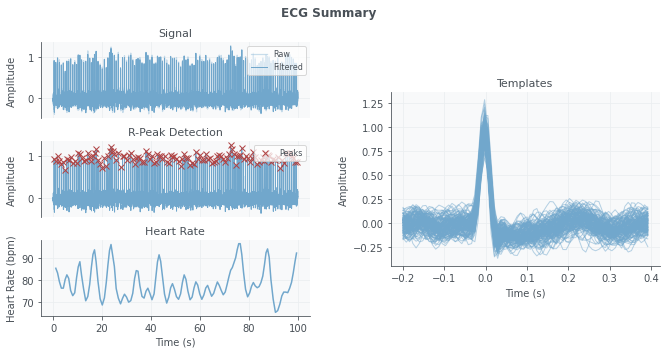

,Time,HeartRate
0,5.0,78.0
1,6.0,84.0
2,7.0,78.0
3,8.0,78.0
4,9.0,78.0
...,...,...
85,90.0,72.0
86,91.0,78.0
87,92.0,78.0
88,93.0,72.0


In [13]:
# use moving window to calculate heart rate from test data:
r_peaks = biosppy.signals.ecg.ecg(signal=test_data["Value"], sampling_rate=test_ecg_sampling_rate)[2] # get indices of r-peaks
times = np.arange(len(test_data["Value"])) # time vector

window_size_sec = 10 # 10-second sliding window
window_size_samples = int(window_size_sec * test_ecg_sampling_rate)
step_size_samples = int(test_ecg_sampling_rate) # slide window every 1 second

hr_times = []
hr_values = []

for start in range(0, len(test_data["Value"]) - window_size_samples, step_size_samples):
    end = start + window_size_samples
    window_r_peaks = r_peaks[(r_peaks >= start) & (r_peaks < end)]
    num_beats = len(window_r_peaks)
    bpm = (num_beats / window_size_sec) * 60 # bpm
    hr_times.append(start / test_ecg_sampling_rate + window_size_sec / 2) # time at center of window
    hr_values.append(bpm)
    
test_data_hr = pd.DataFrame(dict(Time=hr_times, HeartRate=hr_values))

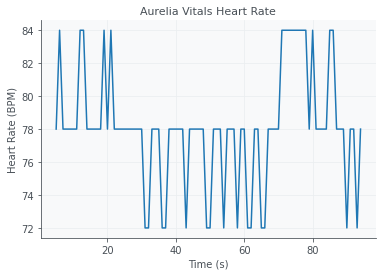

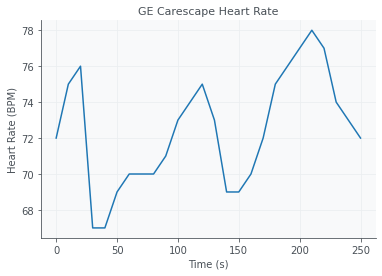

In [14]:
# visualize heart rate changes over time for both test and control device:

# Aurelia Vitals device:
plt.figure()
plt.plot(test_data_hr["Time"], test_data_hr["HeartRate"])
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.title("Aurelia Vitals Heart Rate")
plt.show()

# GE device:
plt.figure()
plt.plot(control_data["Time"], control_data["HR"])
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.title("GE Carescape Heart Rate")
plt.show()

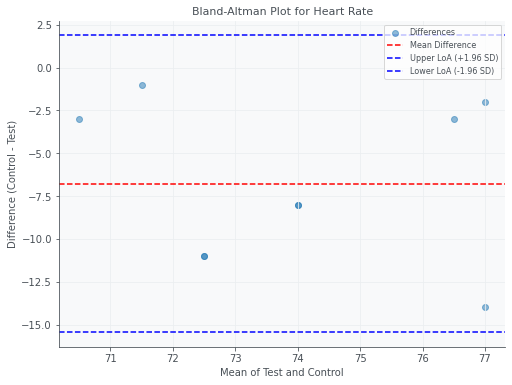

In [15]:
# calculate differences for Bland-Altman plot:

# Determine the overlapping time range
start_time = max(test_data_hr["Time"].min(), control_data['Time'].min())
end_time = min(test_data_hr["Time"].max(), control_data['Time'].max())

# Keep only the overlapping region
test_data_BA = test_data_hr[(test_data_hr["Time"] >= start_time) & (test_data_hr["Time"] <= end_time)]
control_data_BA = control_data[(control_data['Time'] >= start_time) & (control_data['Time'] <= end_time)]

# Interpolate test_data to match control_data time points if sampling rates differ
interp_func = interp1d(test_data_BA['Time'], test_data_BA['HeartRate'], kind='linear', fill_value="extrapolate")
test_data_interp = interp_func(control_data_BA['Time'])  # Get resampled test_data at control_data's timestamps

# Compute mean and difference between the two signals
mean_values = (control_data_BA["HR"] + test_data_interp) / 2
diff_values = control_data_BA["HR"] - test_data_interp  # Difference between signals
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, diff_values, alpha=0.5, label="Differences")
plt.axhline(mean_diff, color='red', linestyle='--', label="Mean Difference")
plt.axhline(loa_upper, color='blue', linestyle='--', label="Upper LoA (+1.96 SD)")
plt.axhline(loa_lower, color='blue', linestyle='--', label="Lower LoA (-1.96 SD)")
plt.xlabel("Mean of Test and Control")
plt.ylabel("Difference (Control - Test)")
plt.title("Bland-Altman Plot for Heart Rate")
plt.legend()
plt.show()

In [16]:
# report difference in average heart rate:
control_avg_hr = np.mean(control_data["HR"])
test_avg_hr = np.mean(test_data_hr["HeartRate"])

hr_abs_difference = np.abs(control_avg_hr - test_avg_hr)
hr_percent_difference = (hr_abs_difference/control_avg_hr)*100

print(hr_abs_difference, "bpm")
print(hr_percent_difference, "%")

5.605128205128196 bpm
7.735314932767149 %


In [18]:
#RR Analysis:

In [32]:
# load data from DUT: 
test_rr_sampling_rate = 32 ## fill in RR sampling rate

## Uncomment the following if you want to use real data:
#file_name = "26_2025-03-06_18-12-55_RR.csv"
#rr_test_data = pd.read_csv(file_name)

## Simulate a respiratory signal (comment out if using real data):
resp_signal = nk.rsp_simulate(duration = 244, sampling_rate = test_rr_sampling_rate)
resp_times = [i * 1/test_rr_sampling_rate for i in range(len(resp_signal))]
resp_test_data = pd.DataFrame(dict(Time=rr_times, Resp=resp_signal))

## Uncomment the following if you want to use real data:
#rr_test_data["Time"] = [i * 1/test_rr_sampling_rate for i in range(len(rr_test_data))]

In [33]:
# Load data from GE Carescape:
control_rr_sampling_rate = 100 ## fill in ECG sampling rate
file_name = "trends3.asc"
control_data = pd.read_table('trends3.asc', skiprows = 1, delimiter="\t")
control_data["Time"] = [i * 10 for i in range(len(control_data))]
control_data

,Time,HR,Imped.,SpO2,PR(SpO2),SupraFound,Calibrated,P5sys,P6dia,ST(III),...,MF3,Delta3,Alpha3,Beta3,BSR3,MF4,Delta4,BSR,VO2,VCO2
0,0,72.0,23.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
1,10,75.0,21.0,100.0,79.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
2,20,76.0,18.0,100.0,74.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
3,30,67.0,18.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
4,40,67.0,24.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
5,50,69.0,21.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
6,60,70.0,18.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
7,70,70.0,20.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
8,80,70.0,20.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
9,90,71.0,22.0,100.0,73.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0


In [34]:
# calculate RR from Aurelia Vitals Device using 10 second moving window:

info, peak_signal = nk.rsp_peaks(resp_test_data["Resp"], sampling_rate = test_rr_sampling_rate) # detect peaks from data
test_rr_peaks = peak_signal["RSP_Peaks"] # store indices where peaks occur

window_sec = 10 # 10-second moving window
window_samples = int(window_sec*test_rr_sampling_rate) # number of samples per window
step_samples = test_rr_sampling_rate # 1 second step

rr_times = []
rr_values = []

for start in range(0, len(resp_test_data) - window_samples, step_samples):
    end = start + window_samples
    window_peaks = test_rr_peaks[(test_rr_peaks >= start) & (test_rr_peaks < end)]
    rr = len(window_peaks) / window_sec * 60 # breaths per minute
    rr_times.append(start / test_rr_sampling_rate + window_sec / 2) # middle time of window
    rr_values.append(rr)

test_data_rr = pd.DataFrame(dict(Time=rr_times, RespRate=rr_values))


Text(0, 0.5, 'Breaths per Minute')

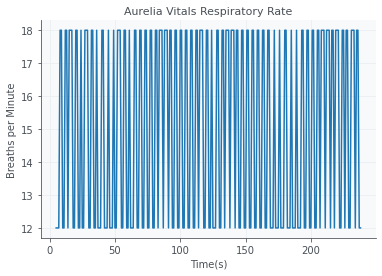

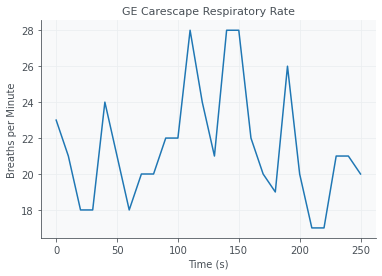

In [35]:
# visualize data:

# plot RR data from Aurelia Vitals:
plt.figure()
plt.plot()
plt.plot(test_data_rr["Time"], test_data_rr["RespRate"])
plt.title("Aurelia Vitals Respiratory Rate")
plt.xlabel("Time(s)")
plt.ylabel("Breaths per Minute")

# plot RR data from GE Carescape:
plt.figure()
plt.plot(control_data["Time"], control_data["Imped."])
plt.title("GE Carescape Respiratory Rate")
plt.xlabel("Time (s)")
plt.ylabel("Breaths per Minute")

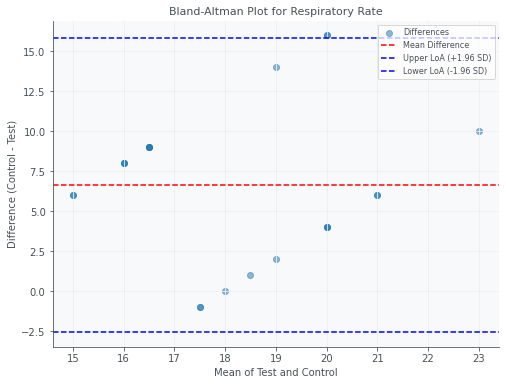

In [36]:
# calculate differences for Bland-Altman plot:

# Determine the overlapping time range
start_time = max(test_data_rr["Time"].min(), control_data['Time'].min())
end_time = min(test_data_rr["Time"].max(), control_data['Time'].max())

# Keep only the overlapping region
test_data_BA = test_data_rr[(test_data_rr["Time"] >= start_time) & (test_data_rr["Time"] <= end_time)]
control_data_BA = control_data[(control_data['Time'] >= start_time) & (control_data['Time'] <= end_time)]

# Interpolate test_data to match control_data time points if sampling rates differ
interp_func = interp1d(test_data_BA['Time'], test_data_BA['RespRate'], kind='linear', fill_value="extrapolate")
test_data_interp = interp_func(control_data_BA['Time'])  # Get resampled test_data at control_data's timestamps

# Compute mean and difference between the two signals
mean_values = (control_data_BA["Imped."] + test_data_interp) / 2
diff_values = control_data_BA["Imped."] - test_data_interp  # Difference between signals
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, diff_values, alpha=0.5, label="Differences")
plt.axhline(mean_diff, color='red', linestyle='--', label="Mean Difference")
plt.axhline(loa_upper, color='blue', linestyle='--', label="Upper LoA (+1.96 SD)")
plt.axhline(loa_lower, color='blue', linestyle='--', label="Lower LoA (-1.96 SD)")
plt.xlabel("Mean of Test and Control")
plt.ylabel("Difference (Control - Test)")
plt.title("Bland-Altman Plot for Respiratory Rate")
plt.legend()
plt.show()

In [37]:
# report difference in average respiratory rate:
control_avg_rr = np.mean(control_data["Imped."])
test_avg_rr = np.mean(test_data_rr["RespRate"])

rr_abs_difference = np.abs(control_avg_rr - test_avg_rr)
rr_percent_difference = (rr_abs_difference/control_avg_rr)*100

print(rr_abs_difference, "breaths per minute")
print(rr_percent_difference, "%")

6.4743589743589745 breaths per minute
30.11329755515802 %


In [ ]:
## SpO2 Analysis:

In [43]:
# load data from Aurelia Vitals device: 
test_spo2_sampling_rate = 0.1 ## fill in SpO2 sampling rate

## Uncomment the following if you want to use real data:
#file_name = "my_spo2_data.csv"
#spo2_test_data = pd.read_csv(file_name)

## Fake spo2 data (comment out if using real data):
import random 
spo2_signal = []
for sample in range(0, len(control_data)):
    spo2_signal.append(control_data["SpO2"][sample] + random.random()) # add a random number in [0, 1) to provided control SpO2 data
spo2_times = [i * 1/test_spo2_sampling_rate for i in range(len(spo2_signal))]
spo2_test_data = pd.DataFrame(dict(Time=spo2_times, SpO2=spo2_signal))

## Uncomment the following if you want to use real data:
#spo2_test_data["Time"] = [i * 1/test_spo2_sampling_rate for i in range(len(spo2_test_data))]

,Time,SpO2
0,0.0,100.369427
1,10.0,100.811522
2,20.0,100.815736
3,30.0,100.571831
4,40.0,100.352965
5,50.0,100.194617
6,60.0,100.319293
7,70.0,100.381589
8,80.0,100.387023
9,90.0,100.012998


In [48]:
# Load data from GE Carescape:
control_spo2_sampling_rate = 10 ## fill in spo2 sampling rate
file_name = "trends3.asc"
control_data = pd.read_table('trends3.asc', skiprows = 1, delimiter="\t")
control_data["Time"] = [i * 1/control_spo2_sampling_rate for i in range(len(control_data))]
control_data

,Time,HR,Imped.,SpO2,PR(SpO2),SupraFound,Calibrated,P5sys,P6dia,ST(III),...,MF3,Delta3,Alpha3,Beta3,BSR3,MF4,Delta4,BSR,VO2,VCO2
0,0,72.0,23.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
1,10,75.0,21.0,100.0,79.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
2,20,76.0,18.0,100.0,74.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
3,30,67.0,18.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
4,40,67.0,24.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
5,50,69.0,21.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
6,60,70.0,18.0,100.0,72.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
7,70,70.0,20.0,100.0,69.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
8,80,70.0,20.0,100.0,70.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0
9,90,71.0,22.0,100.0,73.0,0.0,0.0,-32767.0,-32767.0,-32767.0,...,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0,-32767.0


Text(0, 0.5, '% Blood Oxygenation')

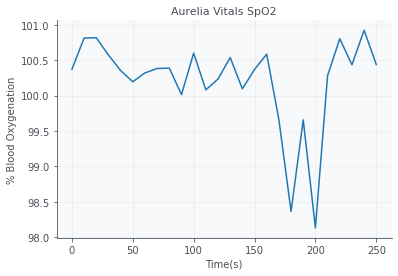

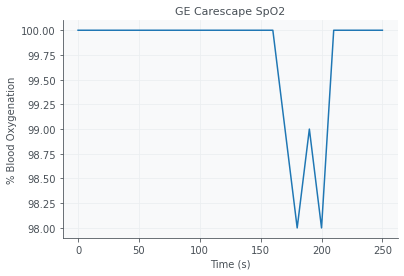

In [49]:
# visualize data:

# plot SpO2 data from Aurelia Vitals:
plt.figure()
plt.plot()
plt.plot(spo2_test_data["Time"], spo2_test_data["SpO2"])
plt.title("Aurelia Vitals SpO2")
plt.xlabel("Time(s)")
plt.ylabel("% Blood Oxygenation")

# plot RR data from GE Carescape:
plt.figure()
plt.plot(control_data["Time"], control_data["SpO2"])
plt.title("GE Carescape SpO2")
plt.xlabel("Time (s)")
plt.ylabel("% Blood Oxygenation")

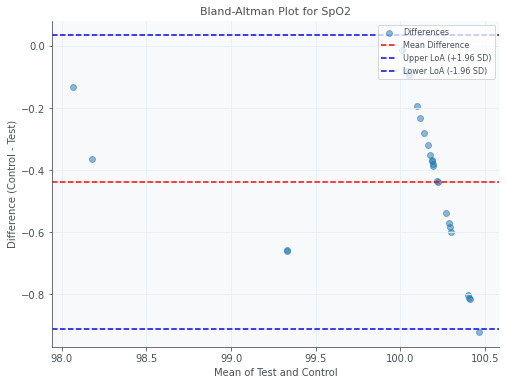

In [50]:
# calculate differences for Bland-Altman plot:

# Determine the overlapping time range
start_time = max(spo2_test_data["Time"].min(), control_data['Time'].min())
end_time = min(spo2_test_data["Time"].max(), control_data['Time'].max())

# Keep only the overlapping region
test_data_BA = spo2_test_data[(spo2_test_data["Time"] >= start_time) & (spo2_test_data["Time"] <= end_time)]
control_data_BA = control_data[(control_data['Time'] >= start_time) & (control_data['Time'] <= end_time)]

# Interpolate test_data to match control_data time points if sampling rates differ
interp_func = interp1d(test_data_BA['Time'], test_data_BA['SpO2'], kind='linear', fill_value="extrapolate")
test_data_interp = interp_func(control_data_BA['Time'])  # Get resampled test_data at control_data's timestamps

# Compute mean and difference between the two signals
mean_values = (control_data_BA["SpO2"] + test_data_interp) / 2
diff_values = control_data_BA["SpO2"] - test_data_interp  # Difference between signals
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, diff_values, alpha=0.5, label="Differences")
plt.axhline(mean_diff, color='red', linestyle='--', label="Mean Difference")
plt.axhline(loa_upper, color='blue', linestyle='--', label="Upper LoA (+1.96 SD)")
plt.axhline(loa_lower, color='blue', linestyle='--', label="Lower LoA (-1.96 SD)")
plt.xlabel("Mean of Test and Control")
plt.ylabel("Difference (Control - Test)")
plt.title("Bland-Altman Plot for SpO2")
plt.legend()
plt.show()

In [53]:
# Calculate root mean squared error between test and control:

rmse = np.sqrt(np.mean(( control_data_BA["SpO2"] - test_data_BA["SpO2"]) ** 2))
print(f"RMSE: {rmse}%")

RMSE: 0.5002680932137366%


In [ ]:
# Temperature Analysis:

In [54]:
# load data from Aurelia Vitals device: 
test_temp_sampling_rate = 1 ## fill in temp sampling rate

file_name = "12_2025-01-16_11-09-30_Temp.csv"
temp_test_data = pd.read_csv(file_name)
temp_test_data["Time"] = [i * 1/test_temp_sampling_rate for i in range(len(temp_test_data))]
temp_test_data

,Time,Value,Aggregate
0,0.0,35.539062,35.546875
1,1.0,35.539062,35.539062
2,2.0,35.539062,35.539062
3,3.0,35.546875,35.539062
4,4.0,35.546875,35.546875
...,...,...,...
3650,3650.0,37.375000,37.367188
3651,3651.0,37.382812,37.375000
3652,3652.0,37.390625,37.382812
3653,3653.0,37.382812,37.390625


In [55]:
# load data from GE Carescape: 
control_temp_sampling_rate = 0.5 ## fill in temp sampling rate

file_name = "sampletempdata.csv"
temp_control_data = pd.read_csv(file_name)
temp_control_data["Time"] = [i * 1/control_temp_sampling_rate for i in range(len(temp_control_data))]
temp_control_data

,Timestamp,Product Type,Version Number,T1,T2,Air Temp,Desired Env Temp,Patient Set Temp,Heated Power,Mode (P or N),...,Boost Air Status,Fan Speed (H or L),Heat Sink Sensor Resistance,Last Weight,Oxygen Set Point,Oxygen Reading,SpO2,Pulse Rate,Alarms,Time
0,2024-10-31 12:36:22.852061,HYB,2.04,32.1,OPEN,33.2,33.0,36.5,14,N,...,D,L,4301,0,0,0,0,0,NaN,0.0
1,2024-10-31 12:36:24.852867,HYB,2.04,32.1,OPEN,33.2,33.0,36.5,14,N,...,D,L,4315,0,0,0,0,0,NaN,2.0
2,2024-10-31 12:36:26.851638,HYB,2.04,32.1,OPEN,33.2,33.0,36.5,0,N,...,D,L,4337,0,0,0,0,0,NaN,4.0
3,2024-10-31 12:36:28.851413,HYB,2.04,32.1,OPEN,33.2,33.0,36.5,0,N,...,D,L,4358,0,0,0,0,0,NaN,6.0
4,2024-10-31 12:36:30.850881,HYB,2.04,32.1,OPEN,33.2,33.0,36.5,0,N,...,D,L,4372,0,0,0,0,0,NaN,8.0


Text(0, 0.5, 'degrees C')

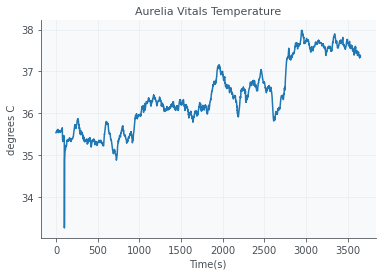

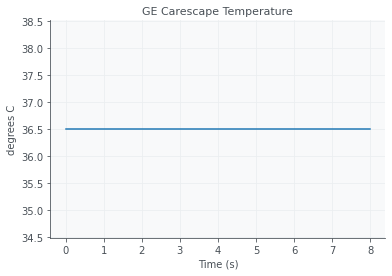

In [56]:
# visualize data:

# plot temp data from Aurelia Vitals:
plt.figure()
plt.plot()
plt.plot(temp_test_data["Time"], temp_test_data["Aggregate"])
plt.title("Aurelia Vitals Temperature")
plt.xlabel("Time(s)")
plt.ylabel("degrees C")

# plot temp data from GE Carescape:
plt.figure()
plt.plot(temp_control_data["Time"], temp_control_data["Patient Set Temp"])
plt.title("GE Carescape Temperature")
plt.xlabel("Time (s)")
plt.ylabel("degrees C")

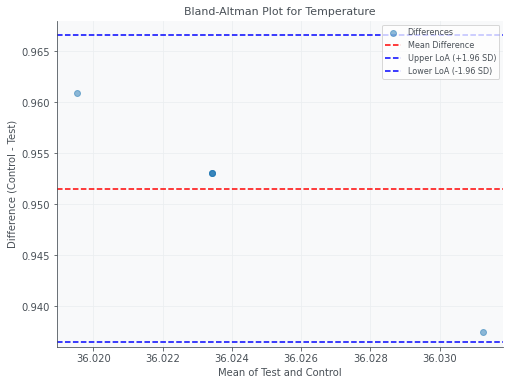

In [57]:
# calculate differences for Bland-Altman plot:

# Determine the overlapping time range
start_time = max(temp_test_data["Time"].min(), temp_control_data['Time'].min())
end_time = min(temp_test_data["Time"].max(), temp_control_data['Time'].max())

# Keep only the overlapping region
test_data_BA = temp_test_data[(temp_test_data["Time"] >= start_time) & (temp_test_data["Time"] <= end_time)]
control_data_BA = temp_control_data[(temp_control_data['Time'] >= start_time) & (temp_control_data['Time'] <= end_time)]

# Interpolate test_data to match control_data time points if sampling rates differ
interp_func = interp1d(test_data_BA['Time'], test_data_BA['Aggregate'], kind='linear', fill_value="extrapolate")
test_data_interp = interp_func(control_data_BA['Time'])  # Get resampled test_data at control_data's timestamps

# Compute mean and difference between the two signals
mean_values = (control_data_BA["Patient Set Temp"] + test_data_interp) / 2
diff_values = control_data_BA["Patient Set Temp"] - test_data_interp  # Difference between signals
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot Bland-Altman plot
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, diff_values, alpha=0.5, label="Differences")
plt.axhline(mean_diff, color='red', linestyle='--', label="Mean Difference")
plt.axhline(loa_upper, color='blue', linestyle='--', label="Upper LoA (+1.96 SD)")
plt.axhline(loa_lower, color='blue', linestyle='--', label="Lower LoA (-1.96 SD)")
plt.xlabel("Mean of Test and Control")
plt.ylabel("Difference (Control - Test)")
plt.title("Bland-Altman Plot for Temperature")
plt.legend()
plt.show()

In [58]:
# report difference in average temperature:
control_avg_temp = np.mean(temp_control_data["Patient Set Temp"])
test_avg_temp = np.mean(temp_test_data["Aggregate"])

temp_abs_difference = np.abs(control_avg_temp - test_avg_temp)
temp_percent_difference = (temp_abs_difference/control_avg_temp)*100

print(temp_abs_difference, "degrees C")
print(temp_percent_difference, "%")

0.0859075752393963 degrees C
0.23536321983396247 %
